In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

pd.plotting.register_matplotlib_converters()
%matplotlib inline


%load_ext autoreload
%autoreload 2
from help_tool import help_tool

#pd.set_option('future.no_silent_downcasting', True)

# Setting graph parameters
sns.set_theme(style='white')

pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Data has no duplicates and no missing values, there's 159571 observations and 8 features

In [2]:
train = help_tool.csv_download(
    r'Archive\train.csv')

help_tool.first_look(train)

Dataset has 159571 observations and 8 features
Columns with all empty values []
Dataset has 0 duplicates


,dtypes,"Null values, Count","Null values, %"
id,object,0,0.0
comment_text,object,0,0.0
toxic,int64,0,0.0
severe_toxic,int64,0,0.0
obscene,int64,0,0.0
threat,int64,0,0.0
insult,int64,0,0.0
identity_hate,int64,0,0.0


In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0


# Cleaning Data

## Extract Information from URLs
In some cases, the domain or specific keywords within the URL might provide context (e.g., links to specific news sites or social media platforms)

In [4]:
train['comment_text'] = train['comment_text'].apply(help_tool.replace_url_with_domain)


train[train['id'] == 'fbf8672ea3b4ddf7']

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159315,fbf8672ea3b4ddf7,nysun - public interest crap..,1,0,0,0,0,0


## Time and API adress

In [5]:
combined_pattern = (
    r'\b(?:\d{1,2}, \d{1,2} [A-Za-z]{3,10} \d{4}|'  # "31, 19 July 2006"
    r'\d{1,2} \d{1,2} [A-Za-z]{3,10} \d{4}|'  # "31 19 July 2006"
    r'\d{1,2} [A-Za-z]{3,10}, \d{4}|'  # "31 July, 2006"
    r'\d{1,2} [A-Za-z]{3,10} \d{4}|'  # "31 July 2006"
    r'\d{1,2}, [A-Za-z]{3,10} \d{4}, \d{1,2}:\d{2}|'  # "31, July 2006, 18:47"
    r'\d{1,2} [A-Za-z]{3,10} \d{4}, \d{1,2}:\d{2}|'  # "31 July 2006, 18:47"
    r'\d{1,2} [A-Za-z]{3,10} \d{4} \d{1,2}:\d{2}|'  # "31 July 2006 18:47"
    r'\d{1,2}:\d{2}, [A-Za-z]{3,10} \d{1,2}, \d{4}|'  # "18:47, July 31, 2006"
    r'\d{1,2}:\d{2}, \d{1,2} [A-Za-z]{3,10} \d{4}|'  # "18:47, 31 July 2006"
    r'\d{1,2}:\d{2} \d{1,2} [A-Za-z]{3,10} \d{4}|'  # "18:47 31 July 2006"
    r'\d{1,2} [A-Za-z]{3,10} \d{1,2}:\d{2}|'  # "26 July 17:03 UTC"
    r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b'  # IP address
    r')\b'
)


# Remove the date pattern from the 'comment_text' column
train['comment_text'] = train['comment_text'].str.replace(combined_pattern, '', regex=True).str.strip()

train[train['id'] == '000103f0d9cfb60f']

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) (UTC),0,0,0,0,0,0


## Wikipedia shortcuts and images

In [6]:
train['comment_text'] = train['comment_text'].replace(
    {'Wikipedia:': '', 'WP:': '', 'Category:': '', 'disambiguation': '', 'otheruses': ''
     })

In [7]:
train = train[~ train['comment_text'].str.contains("Navbox")]

In [8]:
train['comment_text'] = train['comment_text'].apply(help_tool.replace_filenames)

## Text normalization

In [9]:
train['comment_text'] = train['comment_text'].apply(help_tool.clean_text)

In [10]:
train[train['id'] == 'fbf8672ea3b4ddf7']

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159315,fbf8672ea3b4ddf7,nysun public interest crap,1,0,0,0,0,0


## Remove Stop Words (Optional)
Stop words (e.g., "and", "the", "is") are common words that may not carry much information.

In [11]:
train['comment_text'] = train['comment_text'].apply(help_tool.remove_stopwords)


## English leters

In [12]:
train['comment_text'] = train['comment_text'].apply(help_tool.remove_non_ascii)

In [13]:
train = train[train['comment_text'] != '']

# Dublicated values

In [14]:
train[train['comment_text'].duplicated()].shape

(1694, 8)

In [15]:
train = train[~train['comment_text'].duplicated()]

In [16]:
train.shape

(157756, 8)

# Label Distirbution

In [17]:
train[
    (train['toxic'] == 0)
    &
    (train['severe_toxic'] == 0)
    &
    (train['obscene'] == 0)
    &
    (train['threat'] == 0)
    &
    (train['insult'] == 0)
    &
    (train['identity_hate'] == 0)
      ].shape[0] / train.shape[0] * 100

89.83620274347727

In [18]:
train.drop(columns=['id', 'comment_text']).sum() / train.shape[0] * 100

toxic            9.576815
severe_toxic     0.999011
obscene          5.285377
threat           0.294759
insult           4.932934
identity_hate    0.879206
dtype: float64

In [19]:
toxic_df = train[
    (train['toxic'] == 1)
    |
    (train['severe_toxic'] == 1)
    |
    (train['obscene'] == 1)
    |
    (train['threat'] == 1)
    |
    (train['insult'] == 1)
    |
    (train['identity_hate'] == 1)
      ].drop(columns=['id', 'comment_text'])

In [20]:
toxic_df.sum() / toxic_df.shape[0] * 100

toxic            94.224772
severe_toxic      9.829113
obscene          52.001996
threat            2.900087
insult           48.534364
identity_hate     8.650368
dtype: float64

Is one label a subgroup of another?

In [21]:
toxic_df[toxic_df['toxic'] == 0].value_counts()

toxic  severe_toxic  obscene  threat  insult  identity_hate
0      0             1        0       0       0                316
                     0        0       1       0                299
                     1        0       1       0                181
                     0        0       0       1                 54
                                      1       1                 27
                              1       0       0                 21
                     1        0       1       1                 18
                     0        1       1       0                  3
                     1        0       0       1                  3
                              1       0       0                  2
                                      1       0                  2
Name: count, dtype: int64

In [22]:
toxic_df[['insult', 'identity_hate']].value_counts()

insult  identity_hate
0       0                8011
1       0                6636
        1                1146
0       1                 241
Name: count, dtype: int64

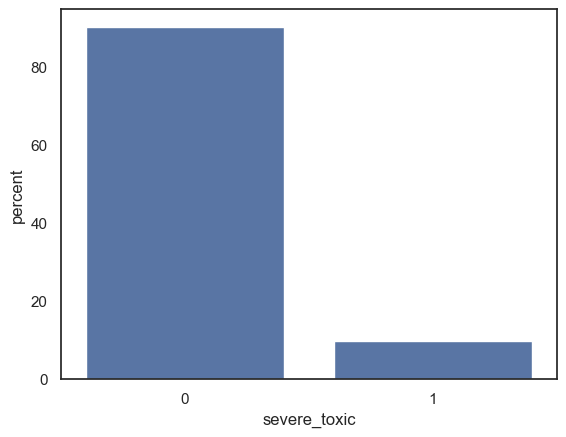

In [23]:
sns.countplot(data=toxic_df, x='severe_toxic', stat="percent")
plt.show()

In [25]:
train['comment_text'].apply(lambda x: len(x.split(" "))).describe()

count    157756.000000
mean         34.348247
std          52.888415
min           1.000000
25%           9.000000
50%          18.000000
75%          38.000000
max        1250.000000
Name: comment_text, dtype: float64

50% of the abstracts have a length of 18. So, any number close to that value is a good enough approximate for the maximum sequence length.

In [26]:
max_seqlen = 18

In [28]:
train['word_count'] = train['comment_text'].apply(lambda x: len(x.split(" ")))

In [29]:
train['word_count'].describe()

count    157756.000000
mean         34.348247
std          52.888415
min           1.000000
25%           9.000000
50%          18.000000
75%          38.000000
max        1250.000000
Name: word_count, dtype: float64

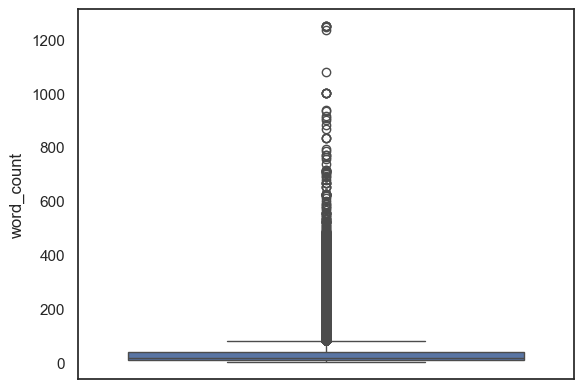

In [71]:
sns.boxplot(train['word_count'])
plt.show()

In [90]:
threshold = train['word_count'].quantile(0.9)
threshold

77.0

In [84]:
train[train['word_count'] > threshold].drop(columns=['id', 'comment_text']).sum() / train.drop(columns=['id', 'comment_text']).sum() * 100

toxic             5.824729
severe_toxic     10.279188
obscene           5.720796
threat            5.376344
insult            5.011565
identity_hate     6.921413
word_count       44.402066
dtype: float64

In [85]:
train[train['word_count'] < threshold].drop(columns=['id', 'comment_text']).sum() / train.drop(columns=['id', 'comment_text']).sum() * 100

toxic            94.056129
severe_toxic     89.657360
obscene          94.183257
threat           94.623656
insult           94.872783
identity_hate    93.006489
word_count       55.221364
dtype: float64

In [98]:
clean_data['word_count'] = clean_data['comment_text'].apply(lambda x: len(x.split(" ")))
clean_data['word_count'].describe()

count    141940.000000
mean         21.081077
std          17.153078
min           1.000000
25%           8.000000
50%          16.000000
75%          30.000000
max          76.000000
Name: word_count, dtype: float64

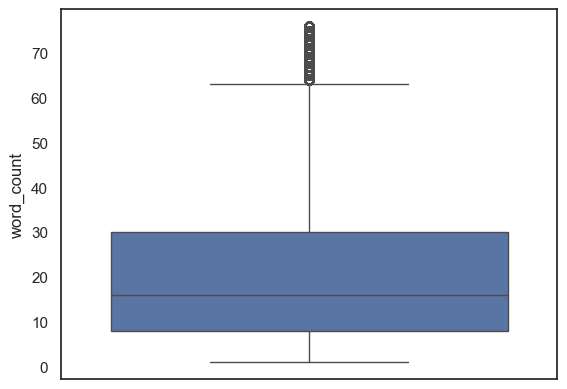

In [99]:
sns.boxplot(clean_data['word_count'])
plt.show()

In [100]:
clean_data.drop(columns='word_count').to_csv(r'Archive\clean_data.csv')